In [1]:
#Data Processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Deep Learning
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

#Image Processing
import os
from pathlib import Path
import joblib
import time

#Machine Learning
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

#Settings       
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

#Set Random seeds
np.random.seed(42)
torch.manual_seed(42)

In [2]:
#Configuration

USE_SUBSET = True
SUBSET_SIZE = 44441
BATCH_SIZE = 64

In [3]:
image_dir = Path('myntradataset/images')

image_paths = list[Path](image_dir.glob('*.jpg'))

fashion_data = []

for img_path in image_paths:
    fashion_data.append({
        'image_id':img_path.stem,
        'image_path':str(img_path),
        'filename': img_path.name
    })

fashion_df = pd.DataFrame(fashion_data)

fashion_df = fashion_df.sample(SUBSET_SIZE, random_state=42).reset_index(drop=True)

print("Total images found:", len(image_paths))

fashion_df.head()

Total images found: 44441


,image_id,image_path,filename
0,34522,myntradataset\images\34522.jpg,34522.jpg
1,6807,myntradataset\images\6807.jpg,6807.jpg
2,20194,myntradataset\images\20194.jpg,20194.jpg
3,27865,myntradataset\images\27865.jpg,27865.jpg
4,45293,myntradataset\images\45293.jpg,45293.jpg


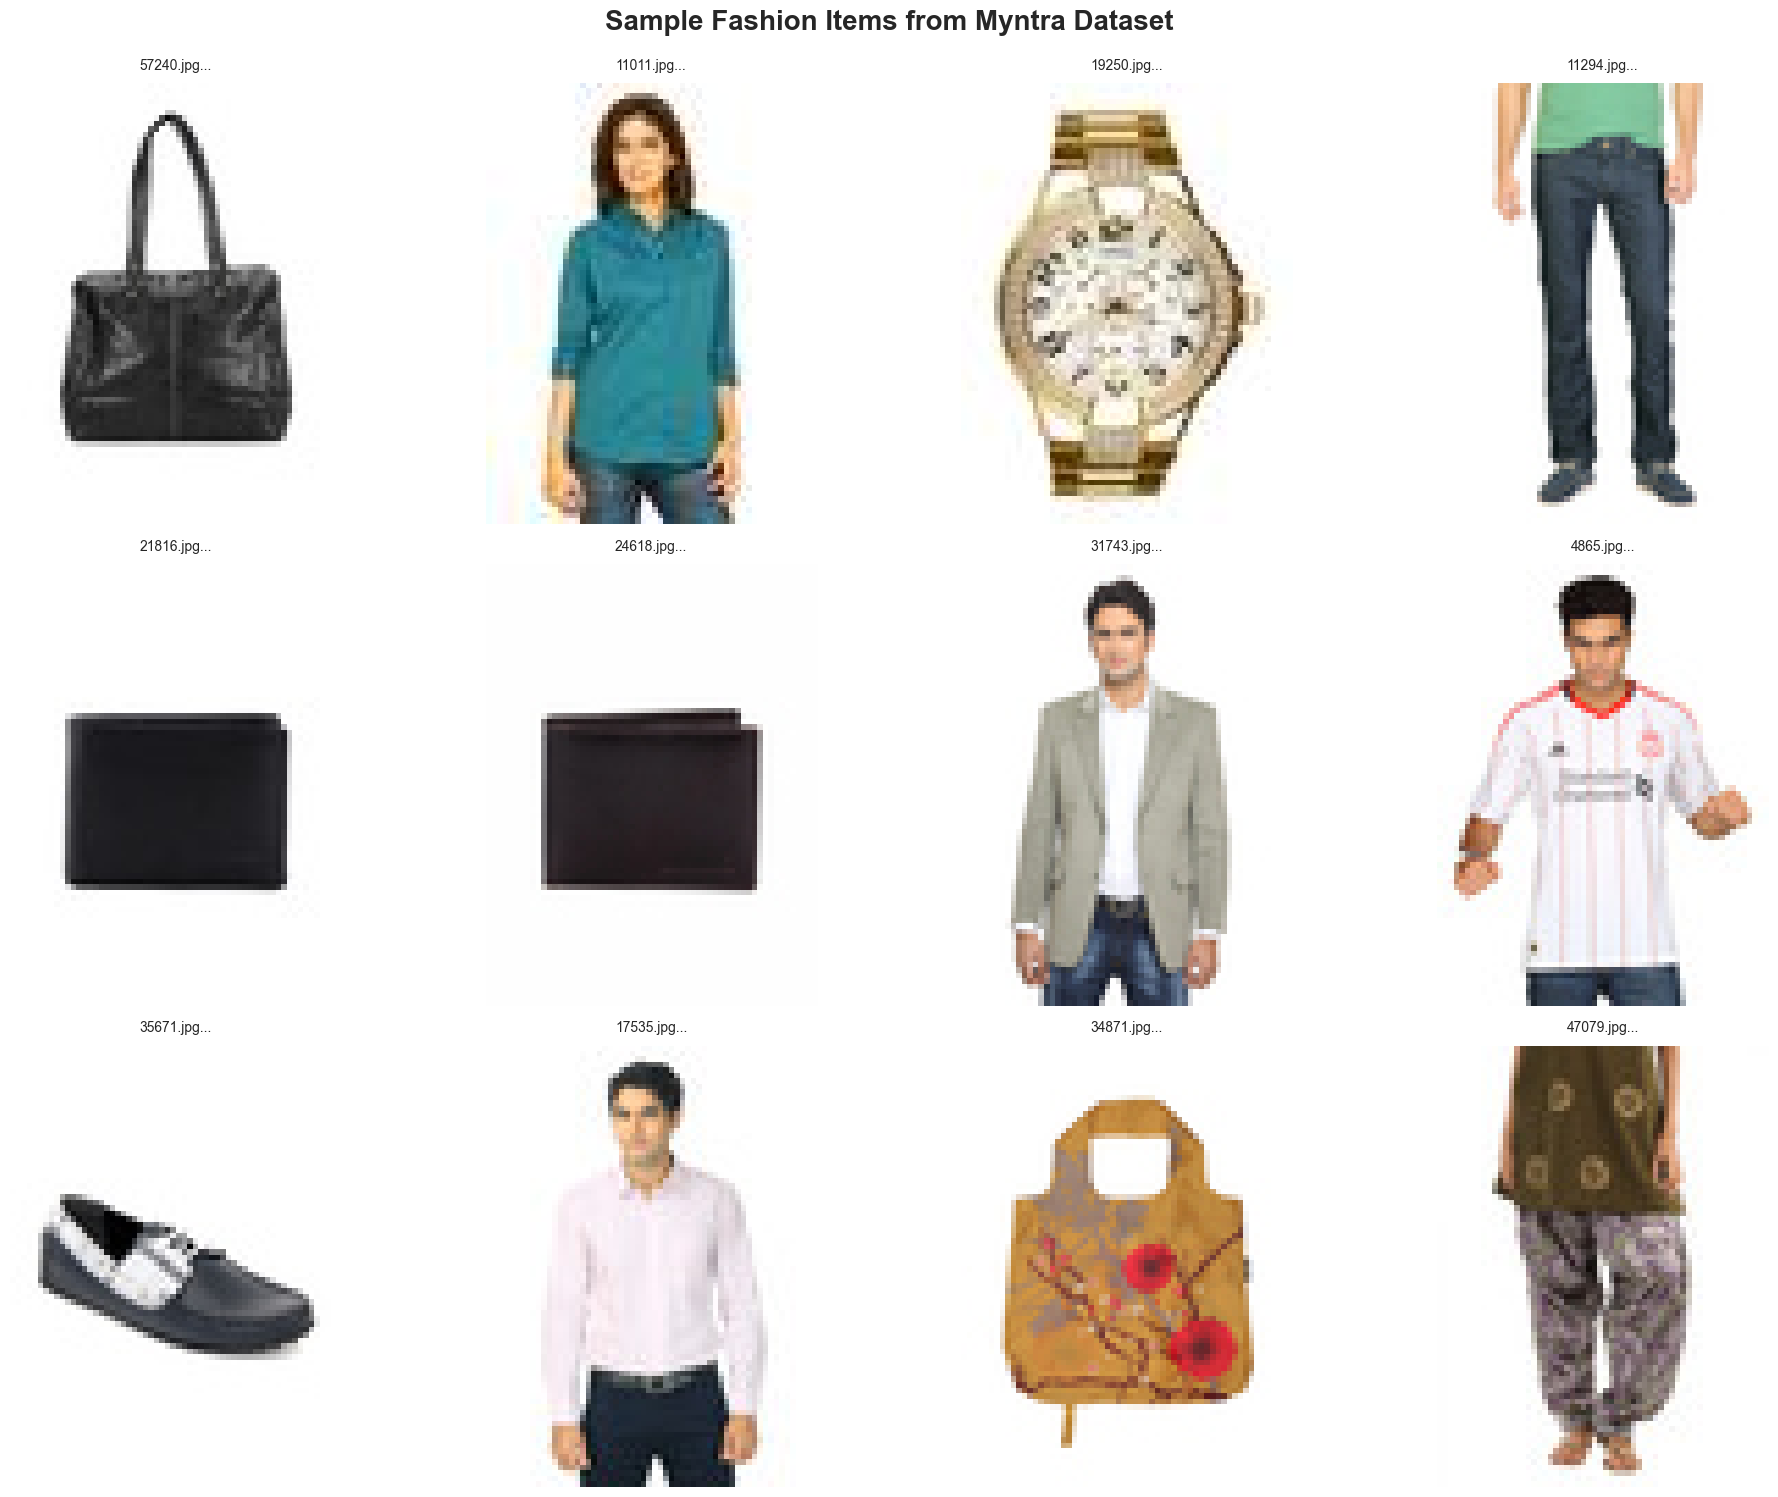

In [4]:
#Display sample images

fig, axes = plt.subplots(3,4, figsize=(20,15))
fig.suptitle('Sample Fashion Items from Myntra Dataset', fontsize=20, fontweight='bold', y=0.995)

sample_items = fashion_df.sample(min(12, len(fashion_df)))

for idx, (ax,(_, item)) in enumerate(zip(axes.flat, sample_items.iterrows())):
    try:
        img = Image.open(item['image_path'])
        ax.imshow(img)
        ax.set_title(f"{item['filename'][:25]}...", fontsize=10, pad =10)
        ax.axis('off')
    except Exception as e:
        ax.text(0.5, 0.5, f'Error loading{item["filename"][:20]}',
                ha='center', va='center', fontsize=9)
        ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
model = models.resnet18(pretrained=True)

model = nn.Sequential(*list(model.children())[:-1])
model = model.to('cpu')
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]

    )
])

In [6]:
all_features = []
failed_images = []
start_time = time.time()

for i in range(0, len(fashion_df), BATCH_SIZE):
    batch_df = fashion_df.iloc[i:i+BATCH_SIZE]
    batch_images = []
    batch_indices = []

    for idx, row in batch_df.iterrows():
        try:
            img = Image.open(row['image_path']).convert('RGB')
            img_tensor = transform(img)
            batch_images.append(img_tensor)
            batch_indices.append(idx)
        except Exception as e:
            failed_images.append(row['filename'])
            continue
    if batch_images:
        batch_tensor = torch.stack(batch_images).to('cpu')

        with torch.no_grad():
            features = model(batch_tensor)
            features = features.squeeze().cpu().numpy()

            if len(features.shape) == 1:
                features = features.reshape(1, -1)
            all_features.extend(features)

    if (i + BATCH_SIZE) % 200 == 0 or (i + BATCH_SIZE) >= len(fashion_df):
        elapsed = time.time() - start_time
        progress = min((i + BATCH_SIZE) / len(fashion_df) * 100, 100)
        print(f"Progress: {progress:.1f}% | Processed:{len(all_features):,}/{len(fashion_df):,} | Time : {elapsed:.1f}s")

features_array = np.array(all_features)

if failed_images:
    fashion_df = fashion_df[~fashion_df['filename'].isin(failed_images)].reset_index(drop=True)


Progress: 3.6% | Processed:1,600/44,441 | Time : 143.7s
Progress: 7.2% | Processed:3,200/44,441 | Time : 286.4s
Progress: 10.8% | Processed:4,800/44,441 | Time : 584.5s
Progress: 14.4% | Processed:6,400/44,441 | Time : 659.2s
Progress: 18.0% | Processed:8,000/44,441 | Time : 751.4s
Progress: 21.6% | Processed:9,600/44,441 | Time : 831.3s
Progress: 25.2% | Processed:11,200/44,441 | Time : 930.4s
Progress: 28.8% | Processed:12,800/44,441 | Time : 1719.0s
Progress: 32.4% | Processed:14,400/44,441 | Time : 1801.5s
Progress: 36.0% | Processed:16,000/44,441 | Time : 1940.8s
Progress: 39.6% | Processed:17,600/44,441 | Time : 2024.0s
Progress: 43.2% | Processed:19,200/44,441 | Time : 2106.5s
Progress: 46.8% | Processed:20,800/44,441 | Time : 2190.0s
Progress: 50.4% | Processed:22,400/44,441 | Time : 2277.6s
Progress: 54.0% | Processed:24,000/44,441 | Time : 2362.9s
Progress: 57.6% | Processed:25,600/44,441 | Time : 2446.5s
Progress: 61.2% | Processed:27,200/44,441 | Time : 2539.9s
Progress: 64

In [7]:
#Build K-Nearest Neighbors model

knn_model = NearestNeighbors(
    n_neighbors=min(20, len(features_array)),
    metric='cosine',
    algorithm='brute'
)

knn_model.fit(features_array)

,n_neighbors,20
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [8]:
n_test = min(10, len(fashion_df))

for test_num in range(n_test):
    test_idx = np.random.randint(0, len(fashion_df))
    query_item = fashion_df.iloc[test_idx]

    query_features = features_array[test_idx].reshape(1,-1)
    distances, indices = knn_model.kneighbors(query_features, n_neighbors=7)

    indices = indices[0][1:]
    distances = distances[0][1:]

    recommendations = fashion_df.iloc[indices].copy()
    recommendations['similarity'] = 1 - distances

    print("Top Recommendations")
    for i, (_, rec) in enumerate(recommendations.iterrows(),1):
        print(f" {i}. {rec['filename'][:35]:35} |Similarity: {rec['similarity']:2%}")
    print()

Top Recommendations
 1. 44670.jpg                           |Similarity: 92.151207%
 2. 9254.jpg                            |Similarity: 91.898018%
 3. 33547.jpg                           |Similarity: 91.829860%
 4. 13416.jpg                           |Similarity: 91.476208%
 5. 33546.jpg                           |Similarity: 91.428924%
 6. 19848.jpg                           |Similarity: 91.351777%

Top Recommendations
 1. 3895.jpg                            |Similarity: 90.510148%
 2. 17803.jpg                           |Similarity: 88.344860%
 3. 9951.jpg                            |Similarity: 88.275373%
 4. 38947.jpg                           |Similarity: 88.207543%
 5. 33152.jpg                           |Similarity: 88.207543%
 6. 38946.jpg                           |Similarity: 88.207543%

Top Recommendations
 1. 29819.jpg                           |Similarity: 96.221542%
 2. 8166.jpg                            |Similarity: 96.074927%
 3. 21235.jpg                           |S

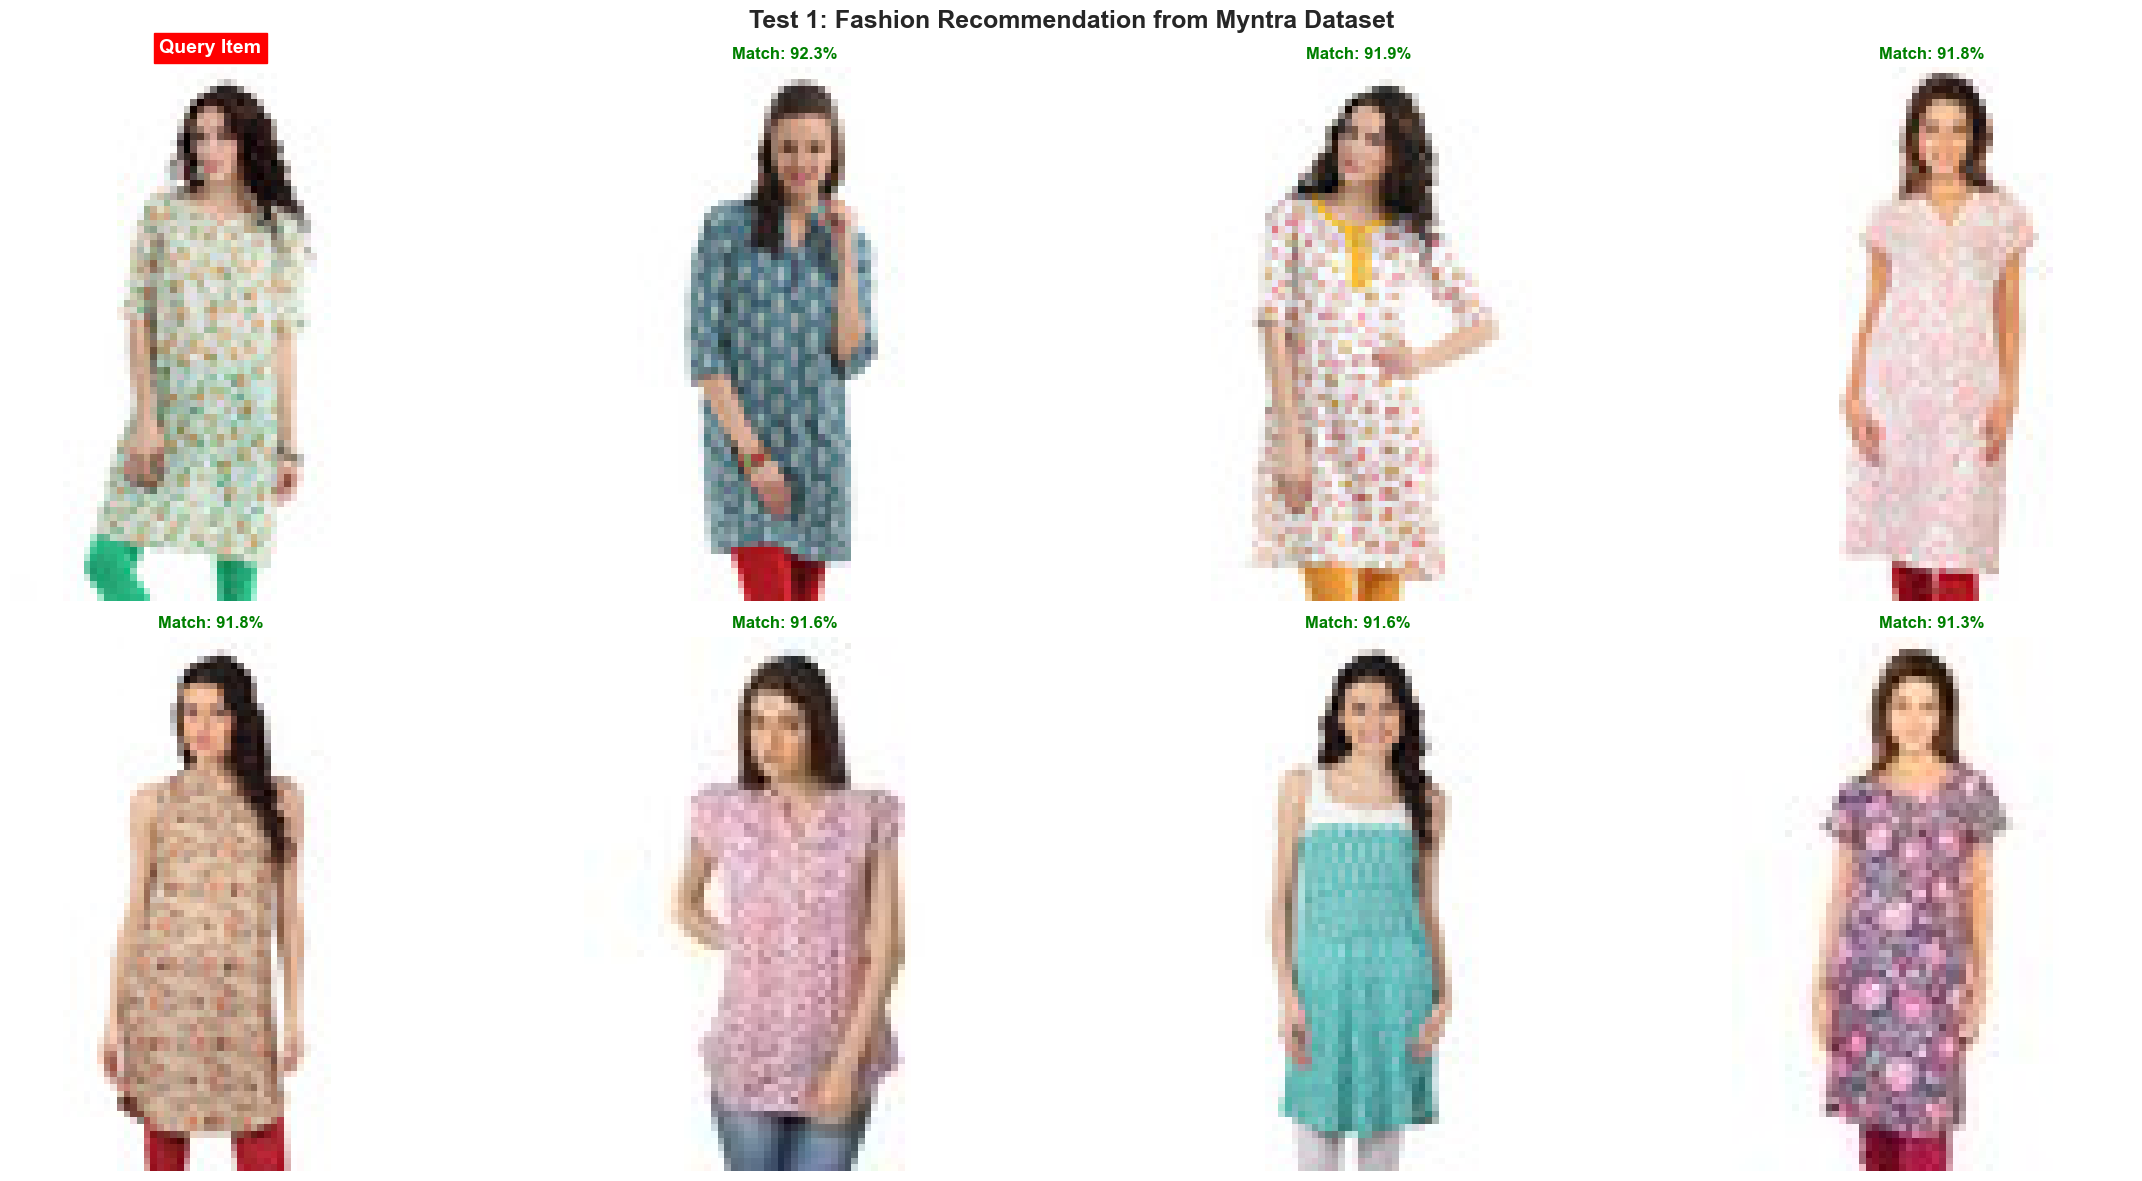

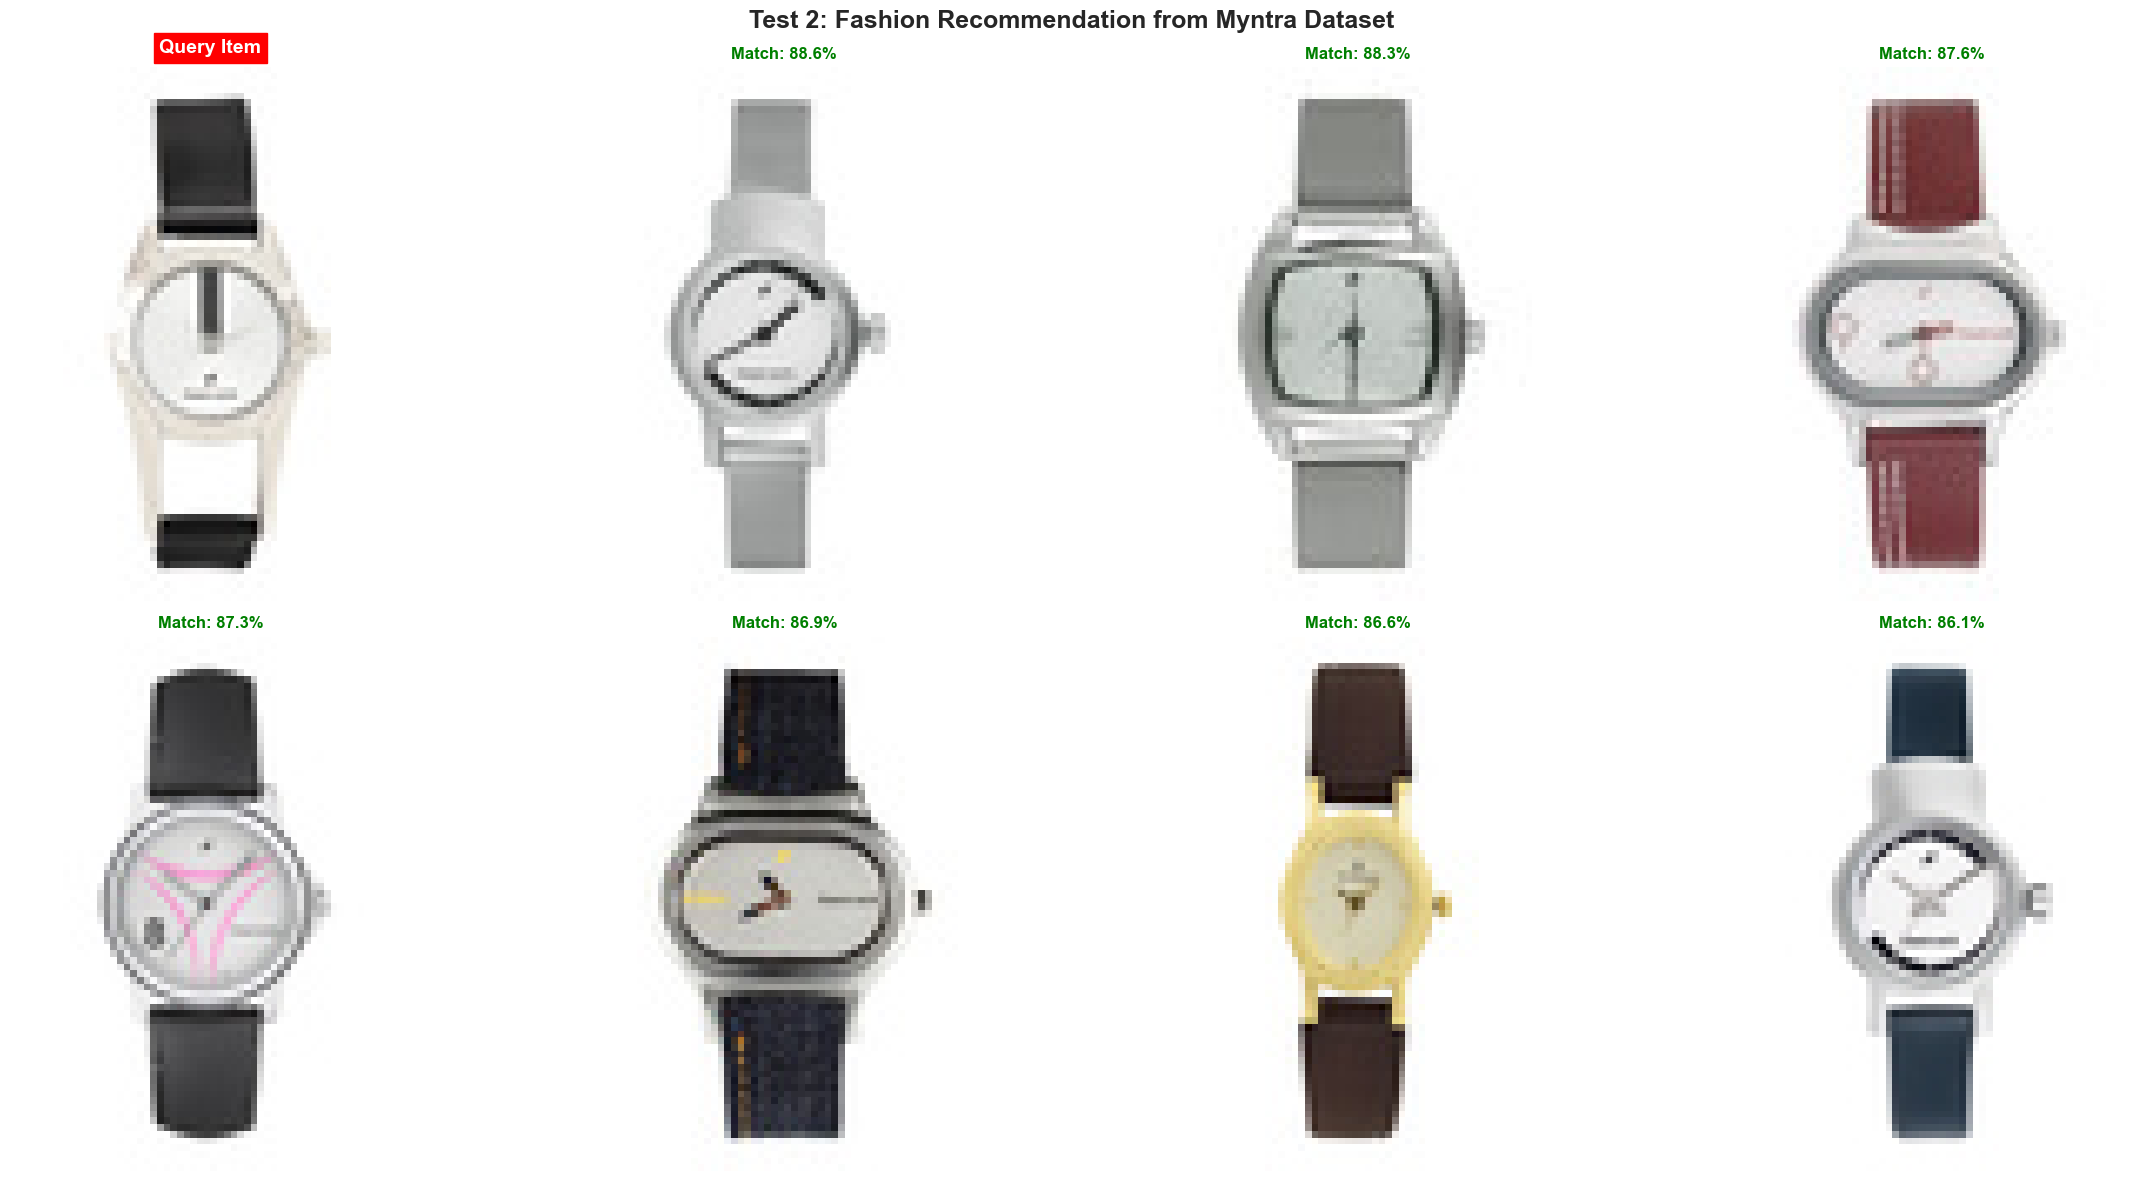

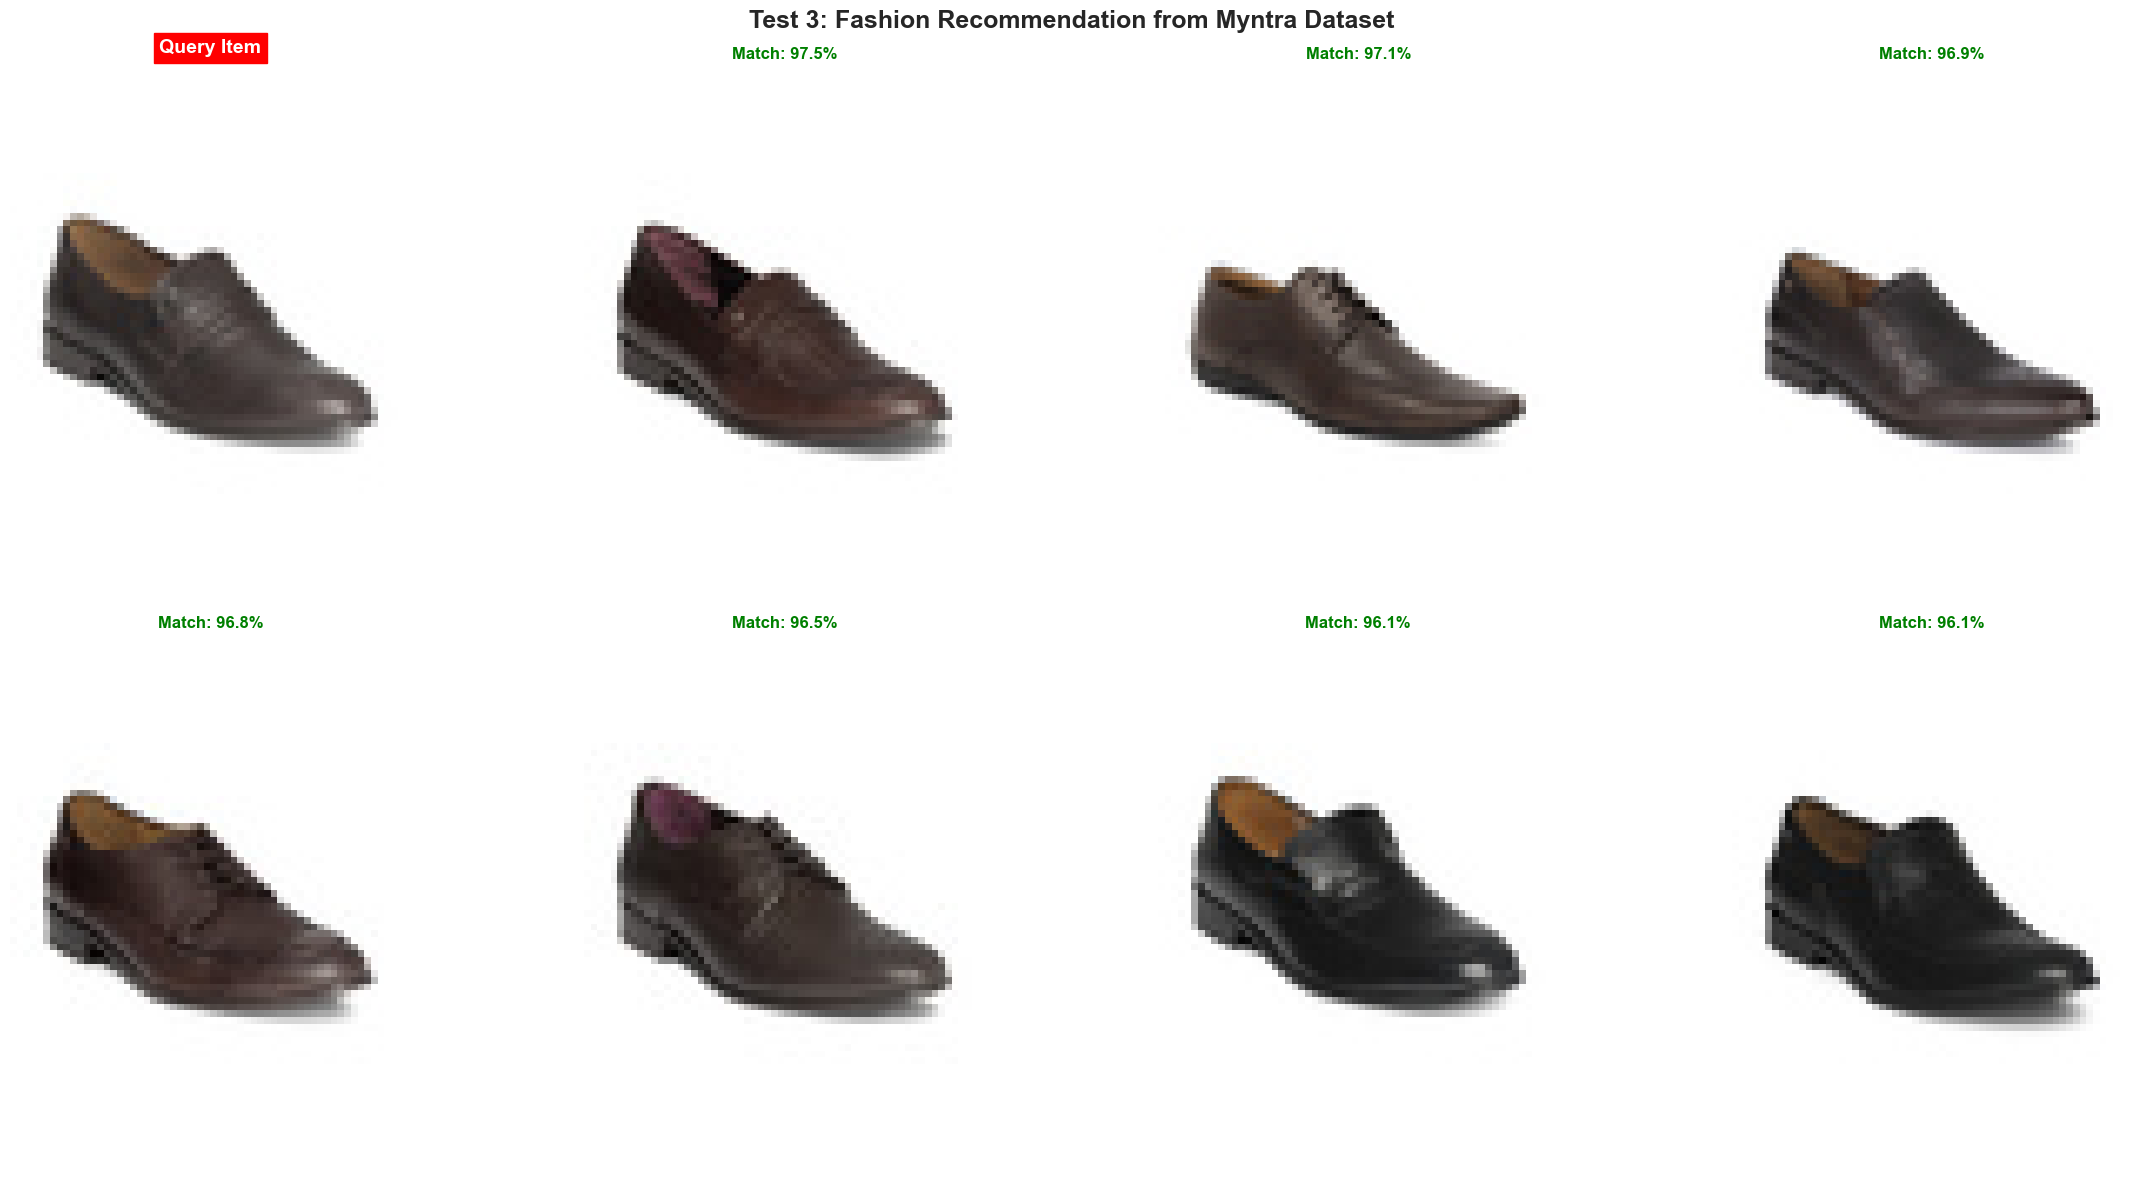

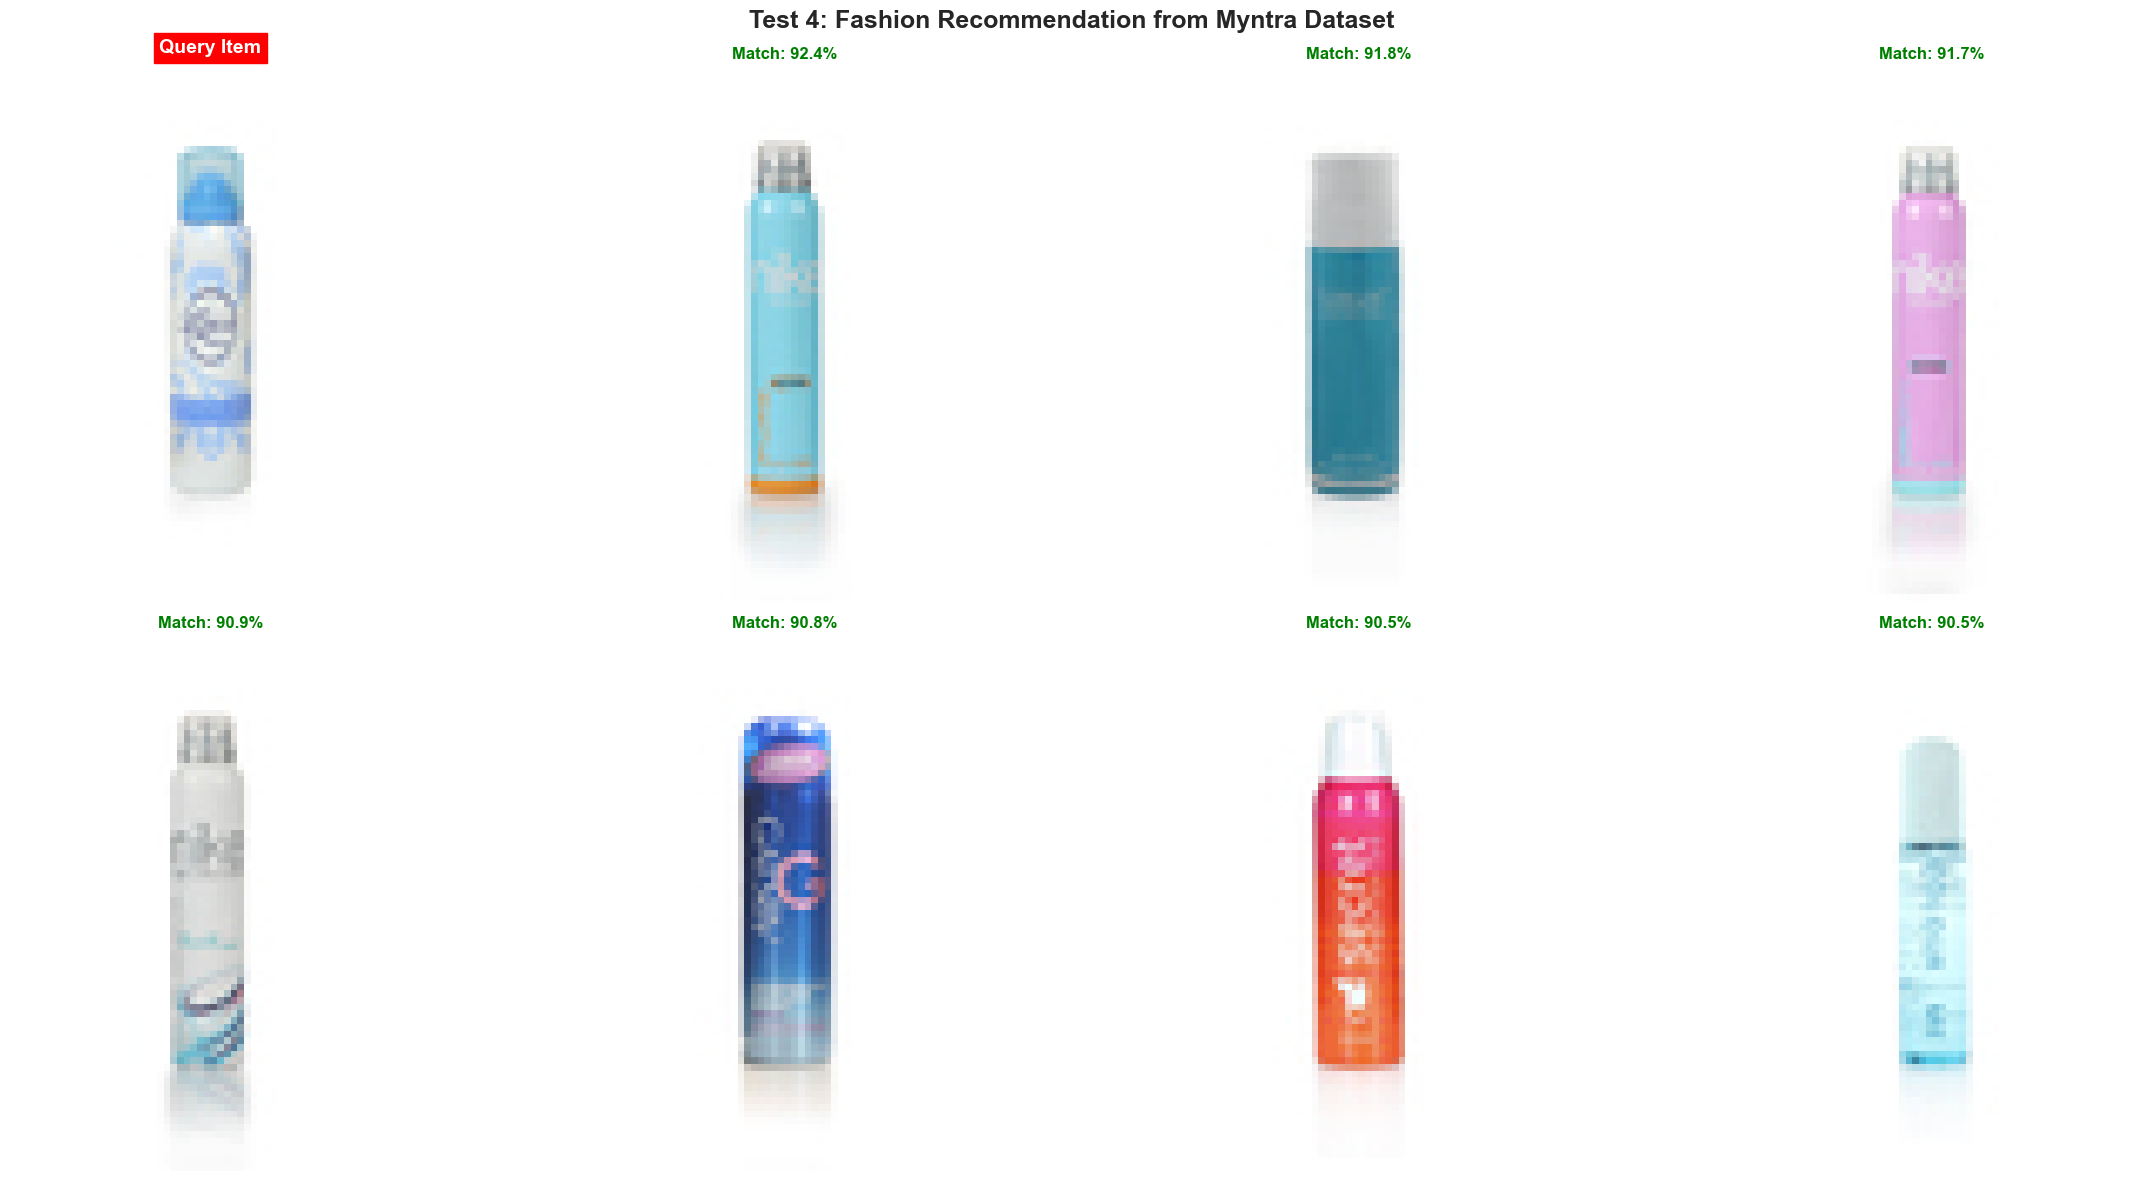

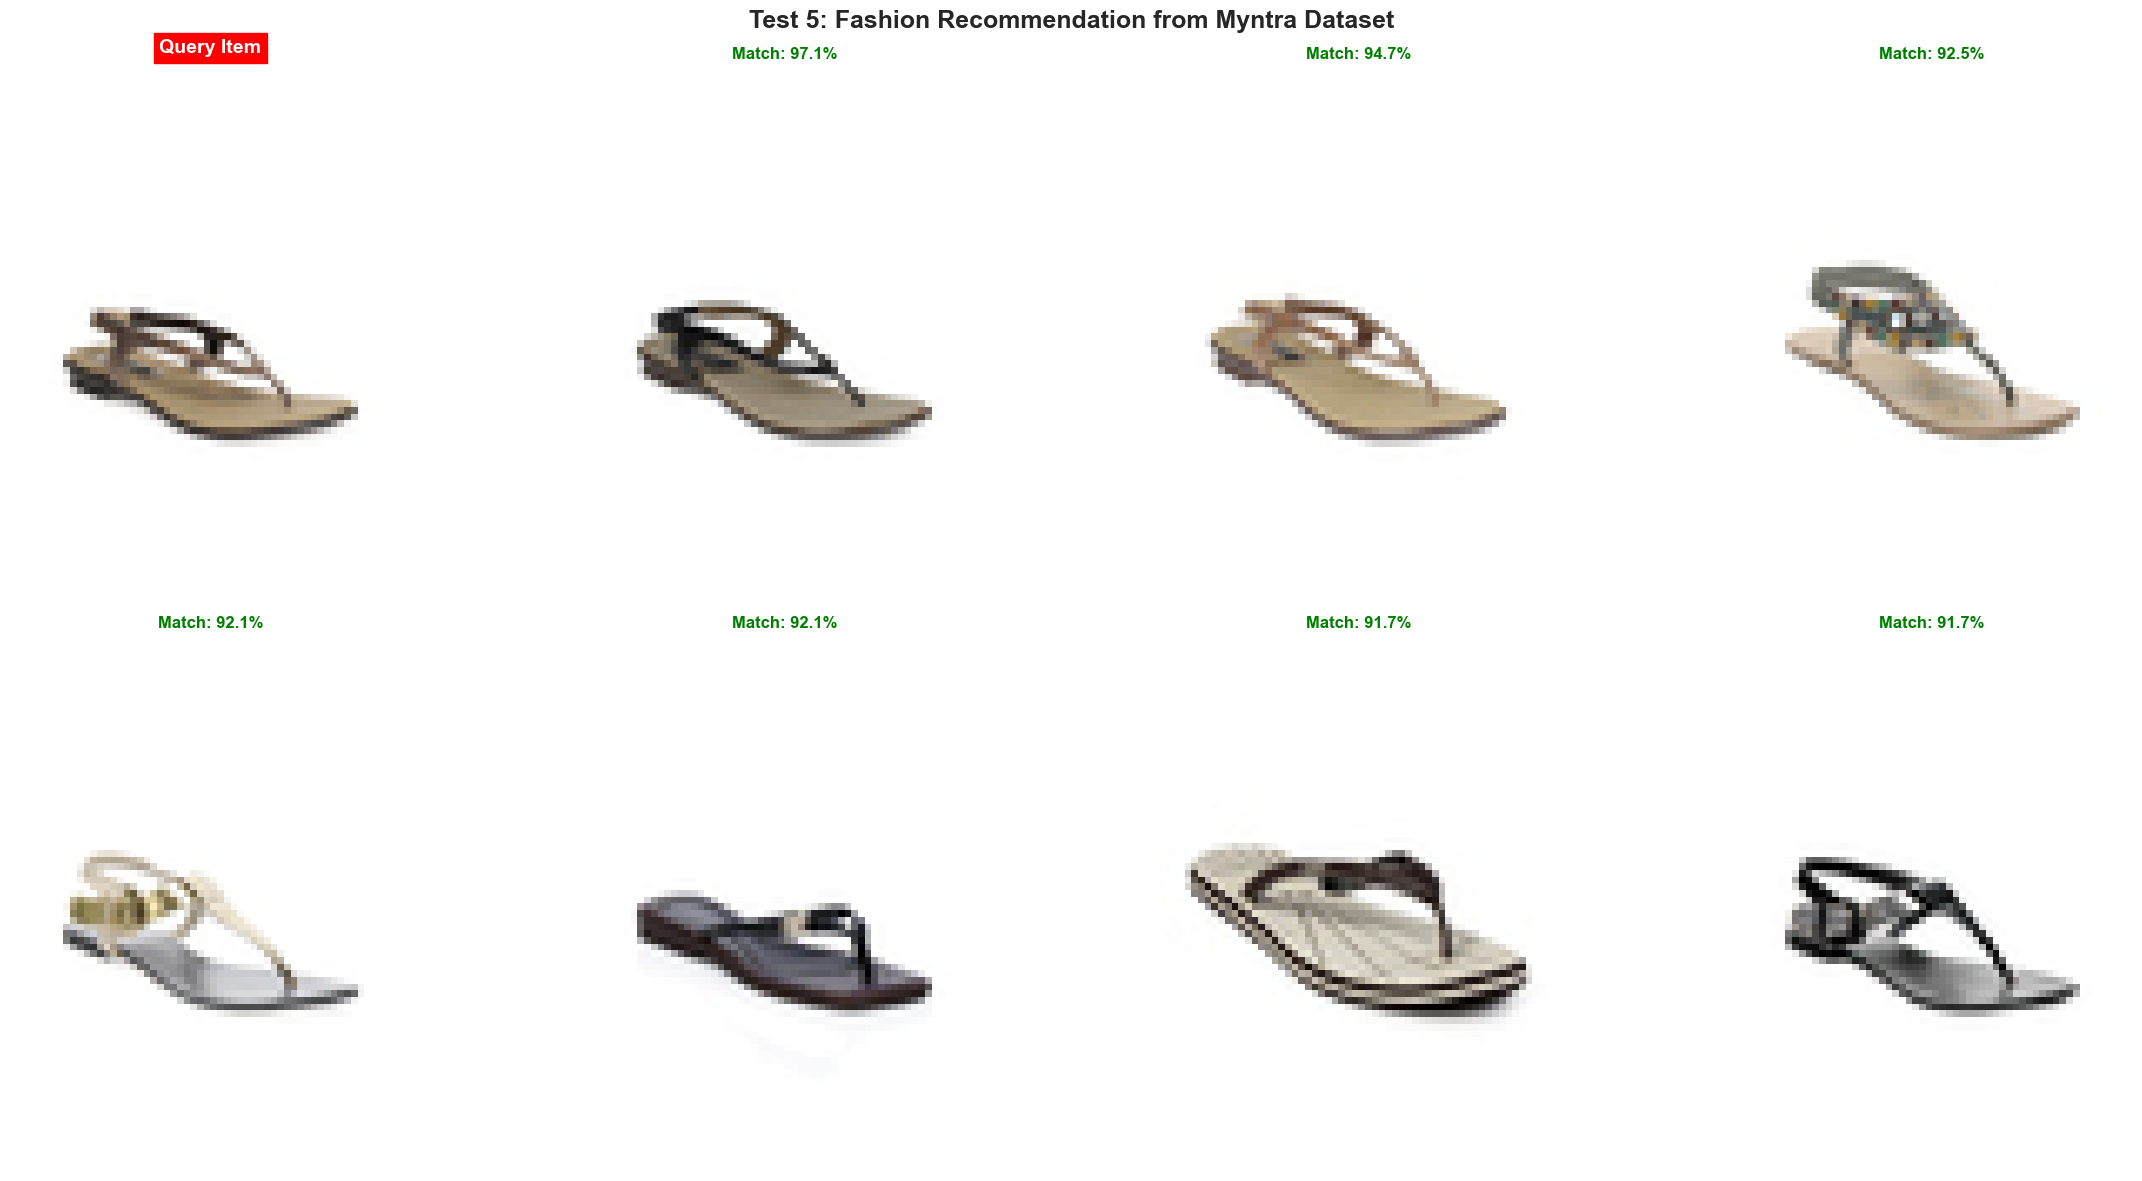

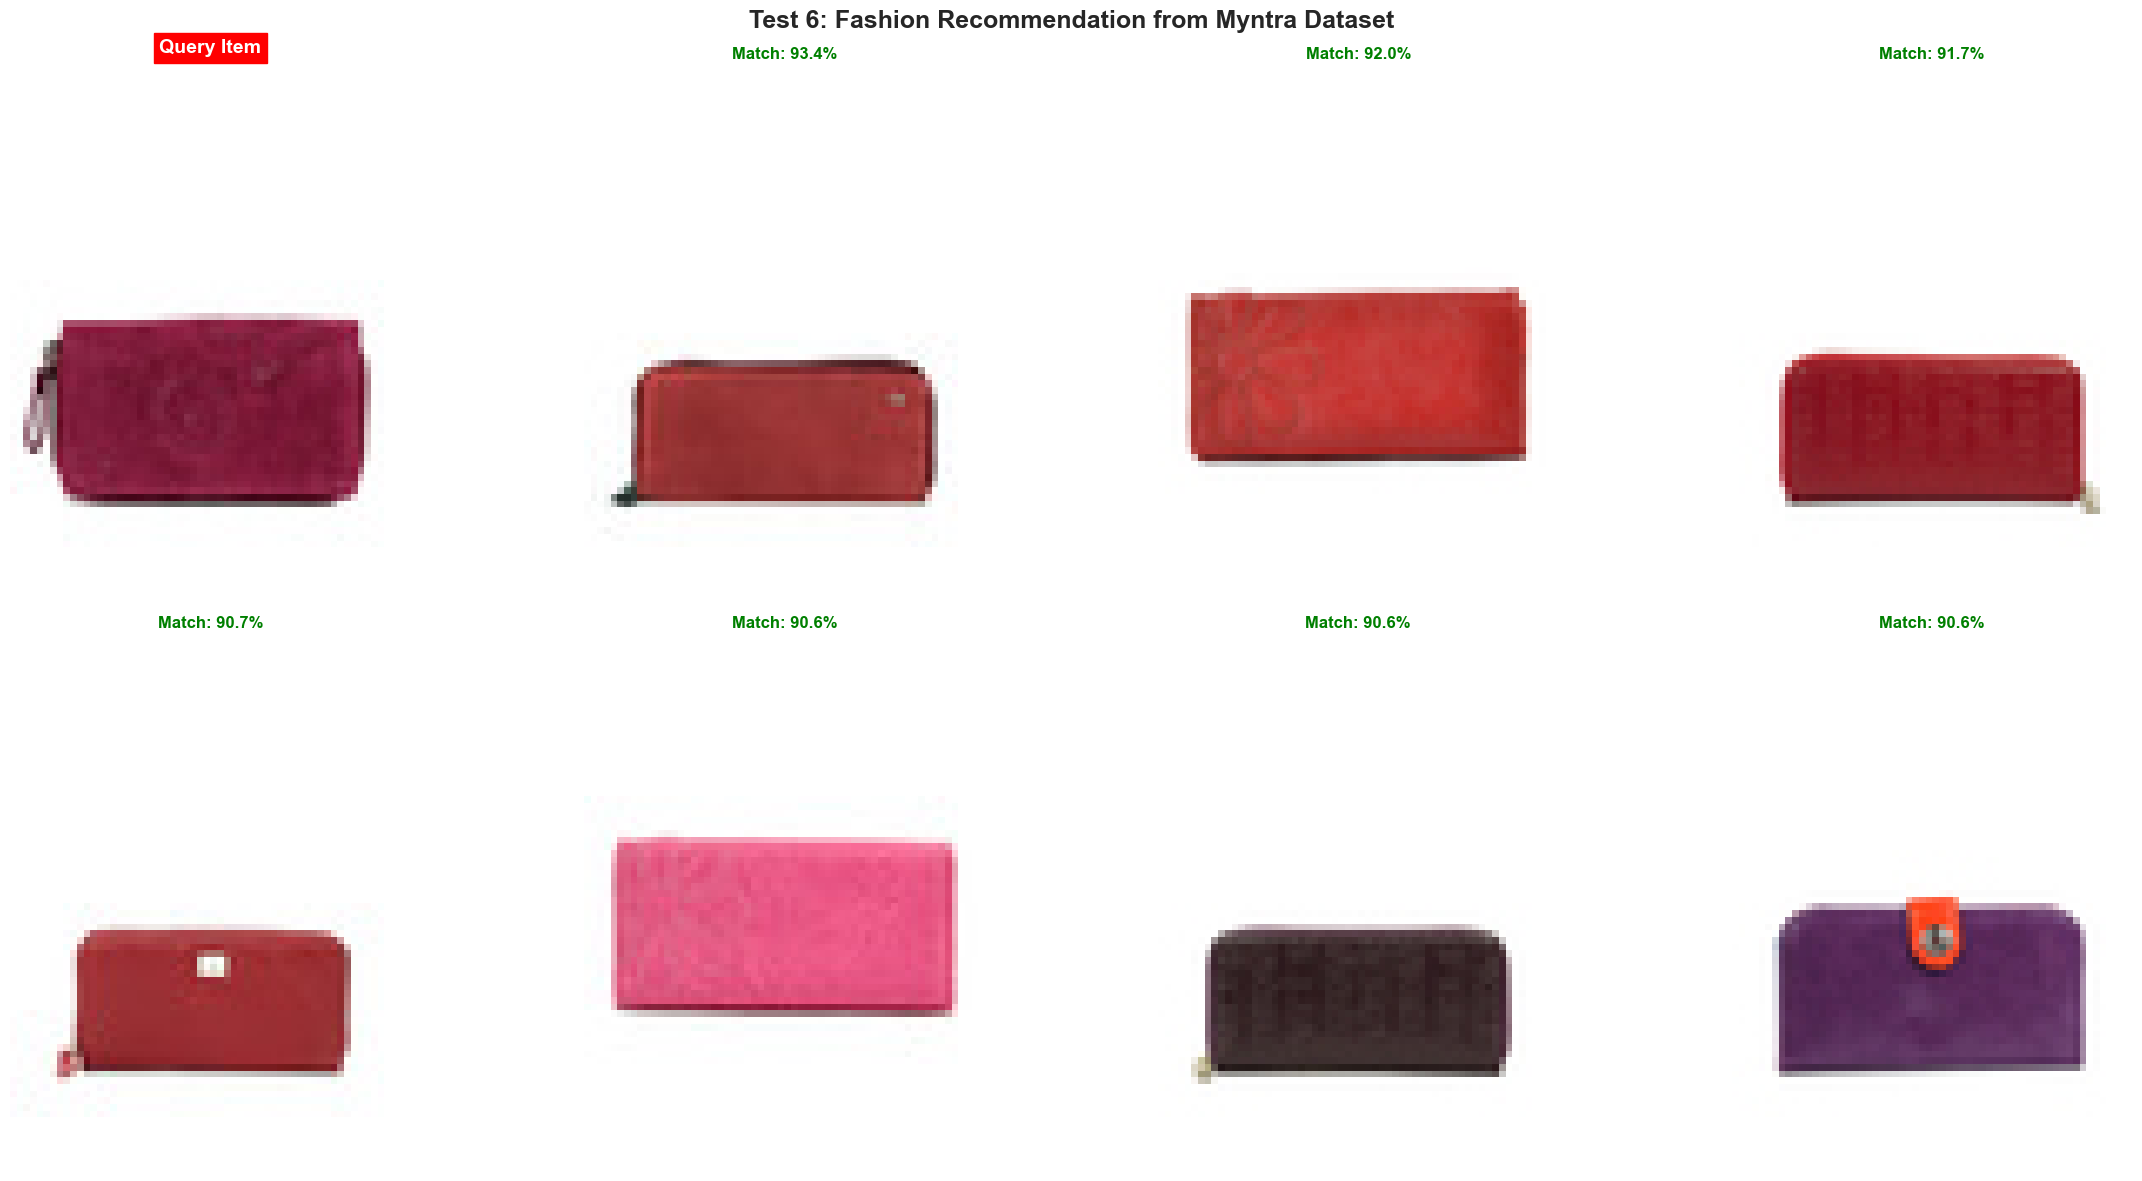

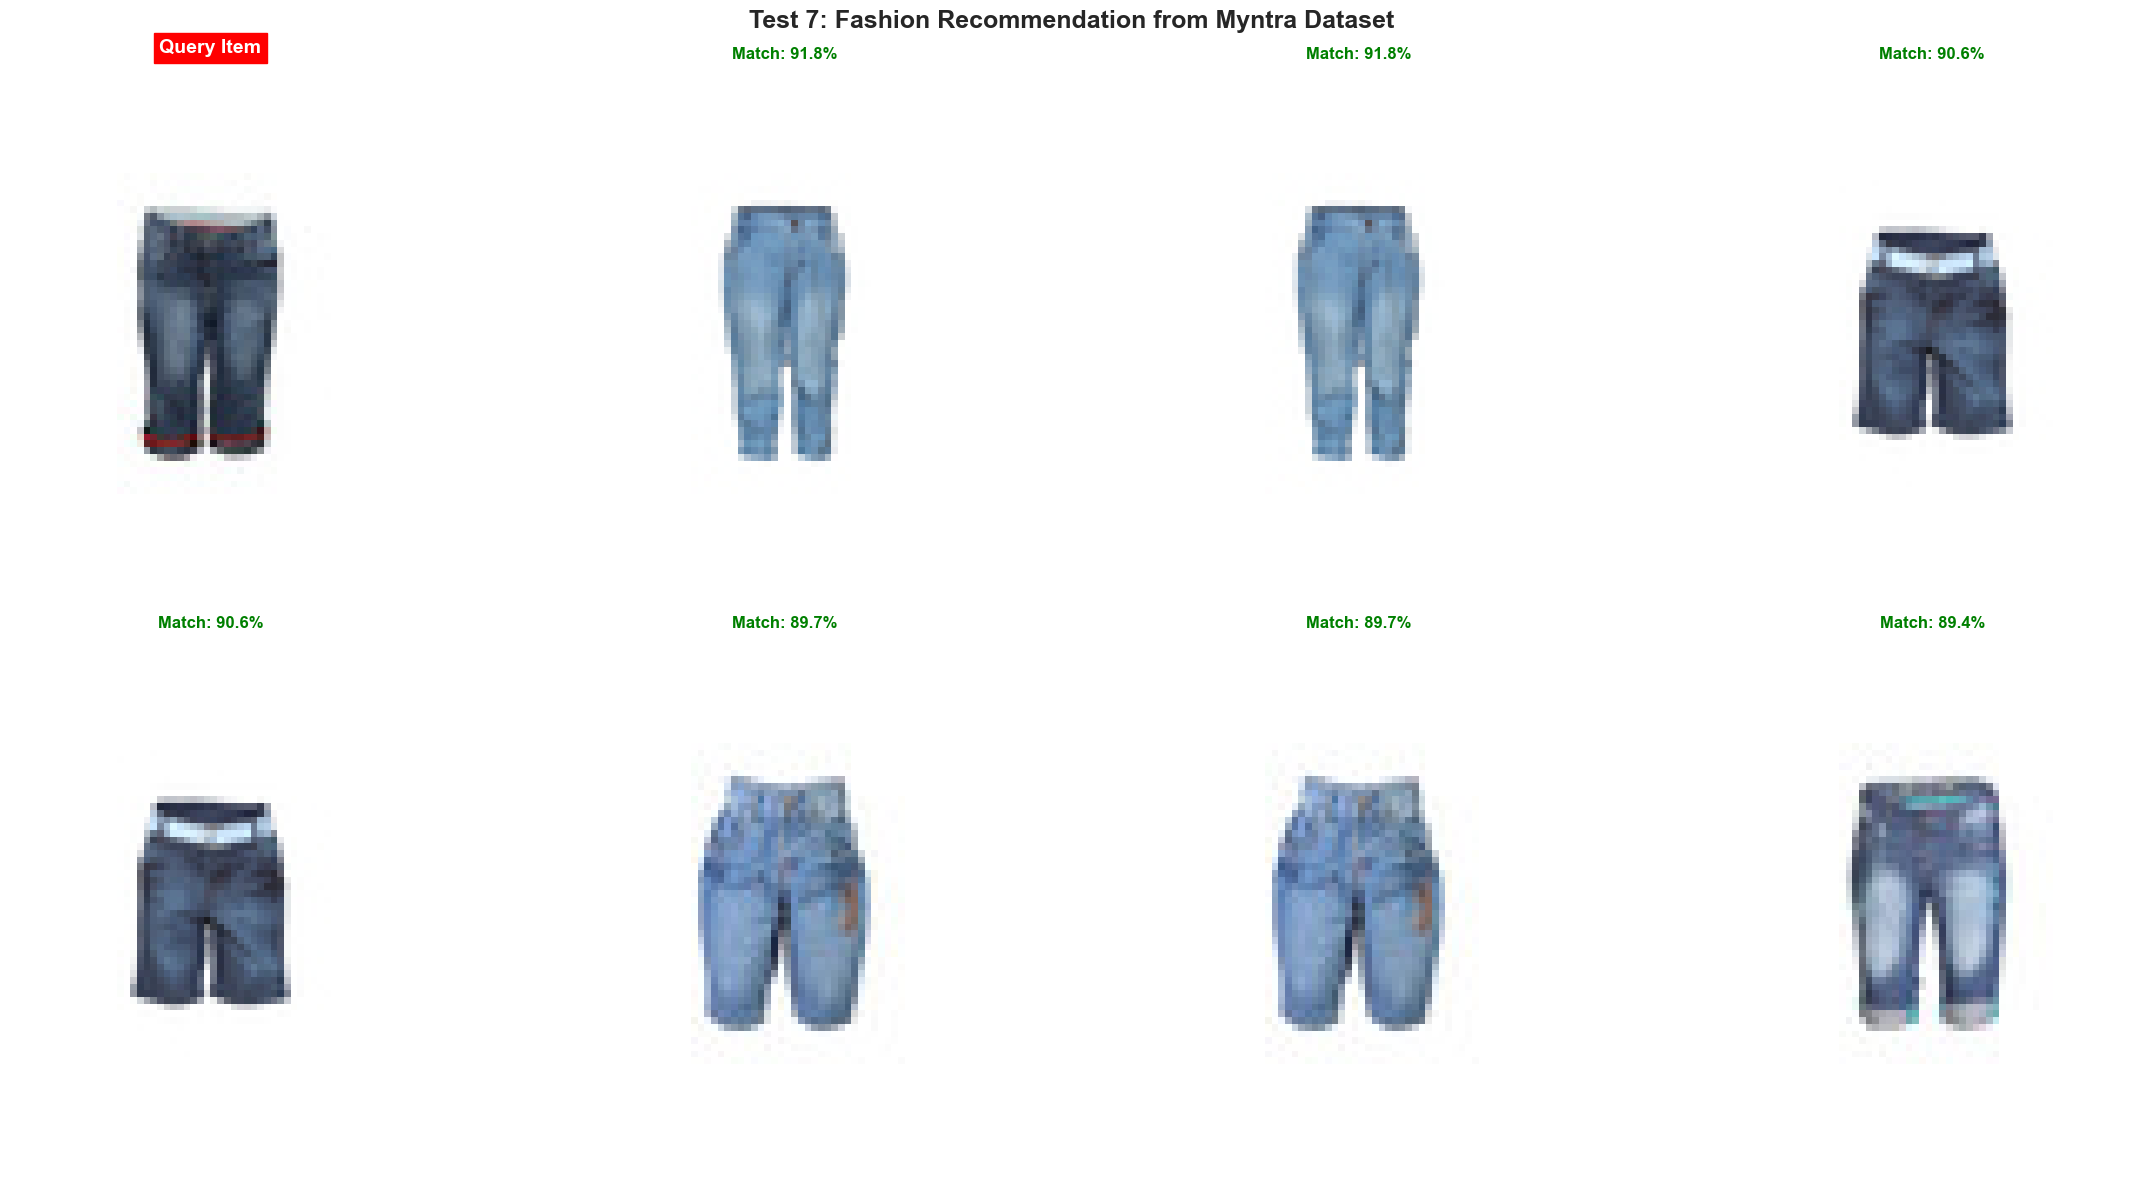

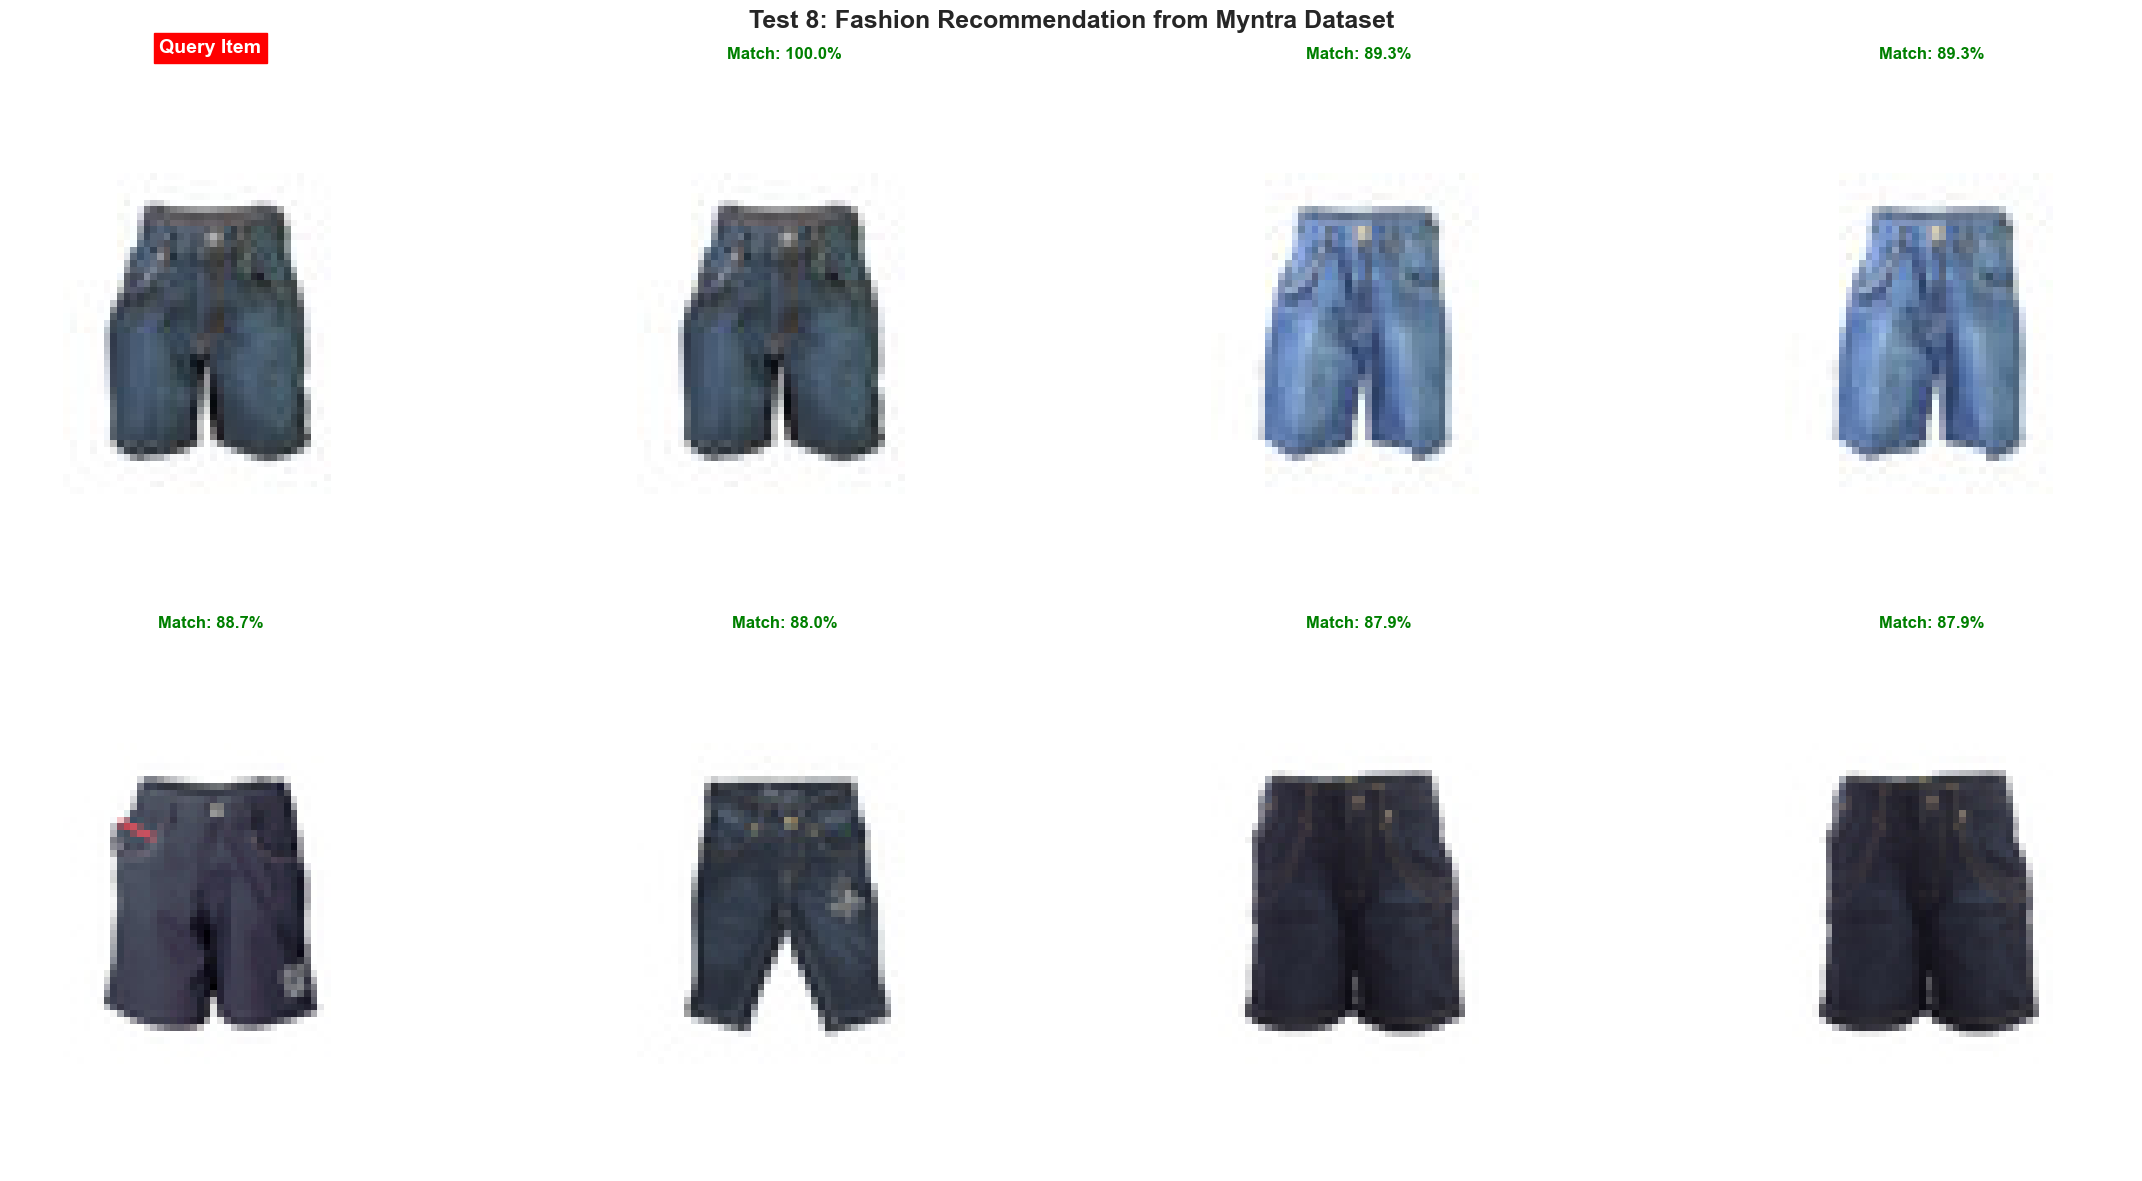

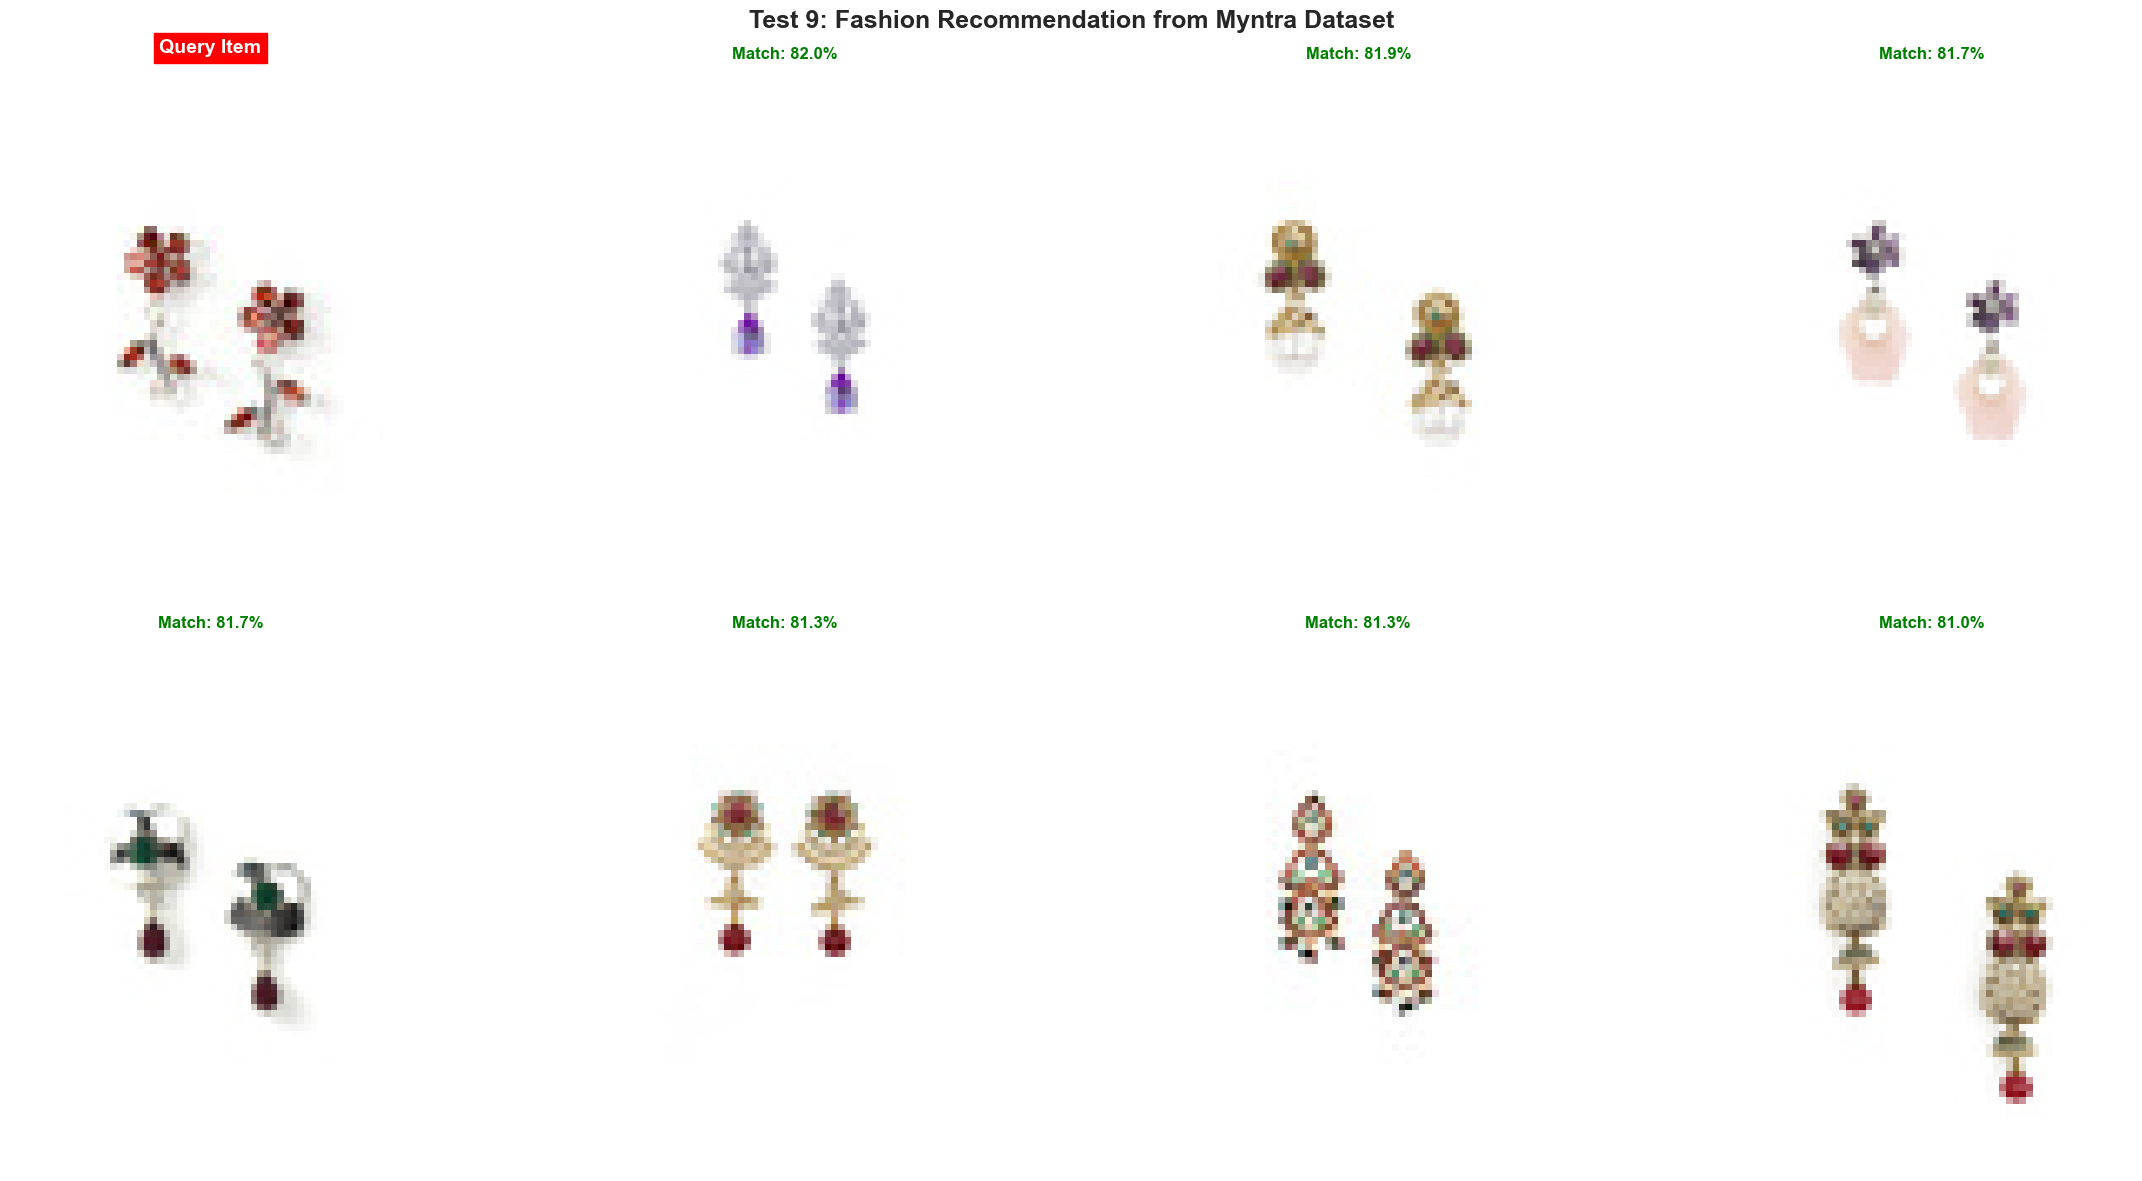

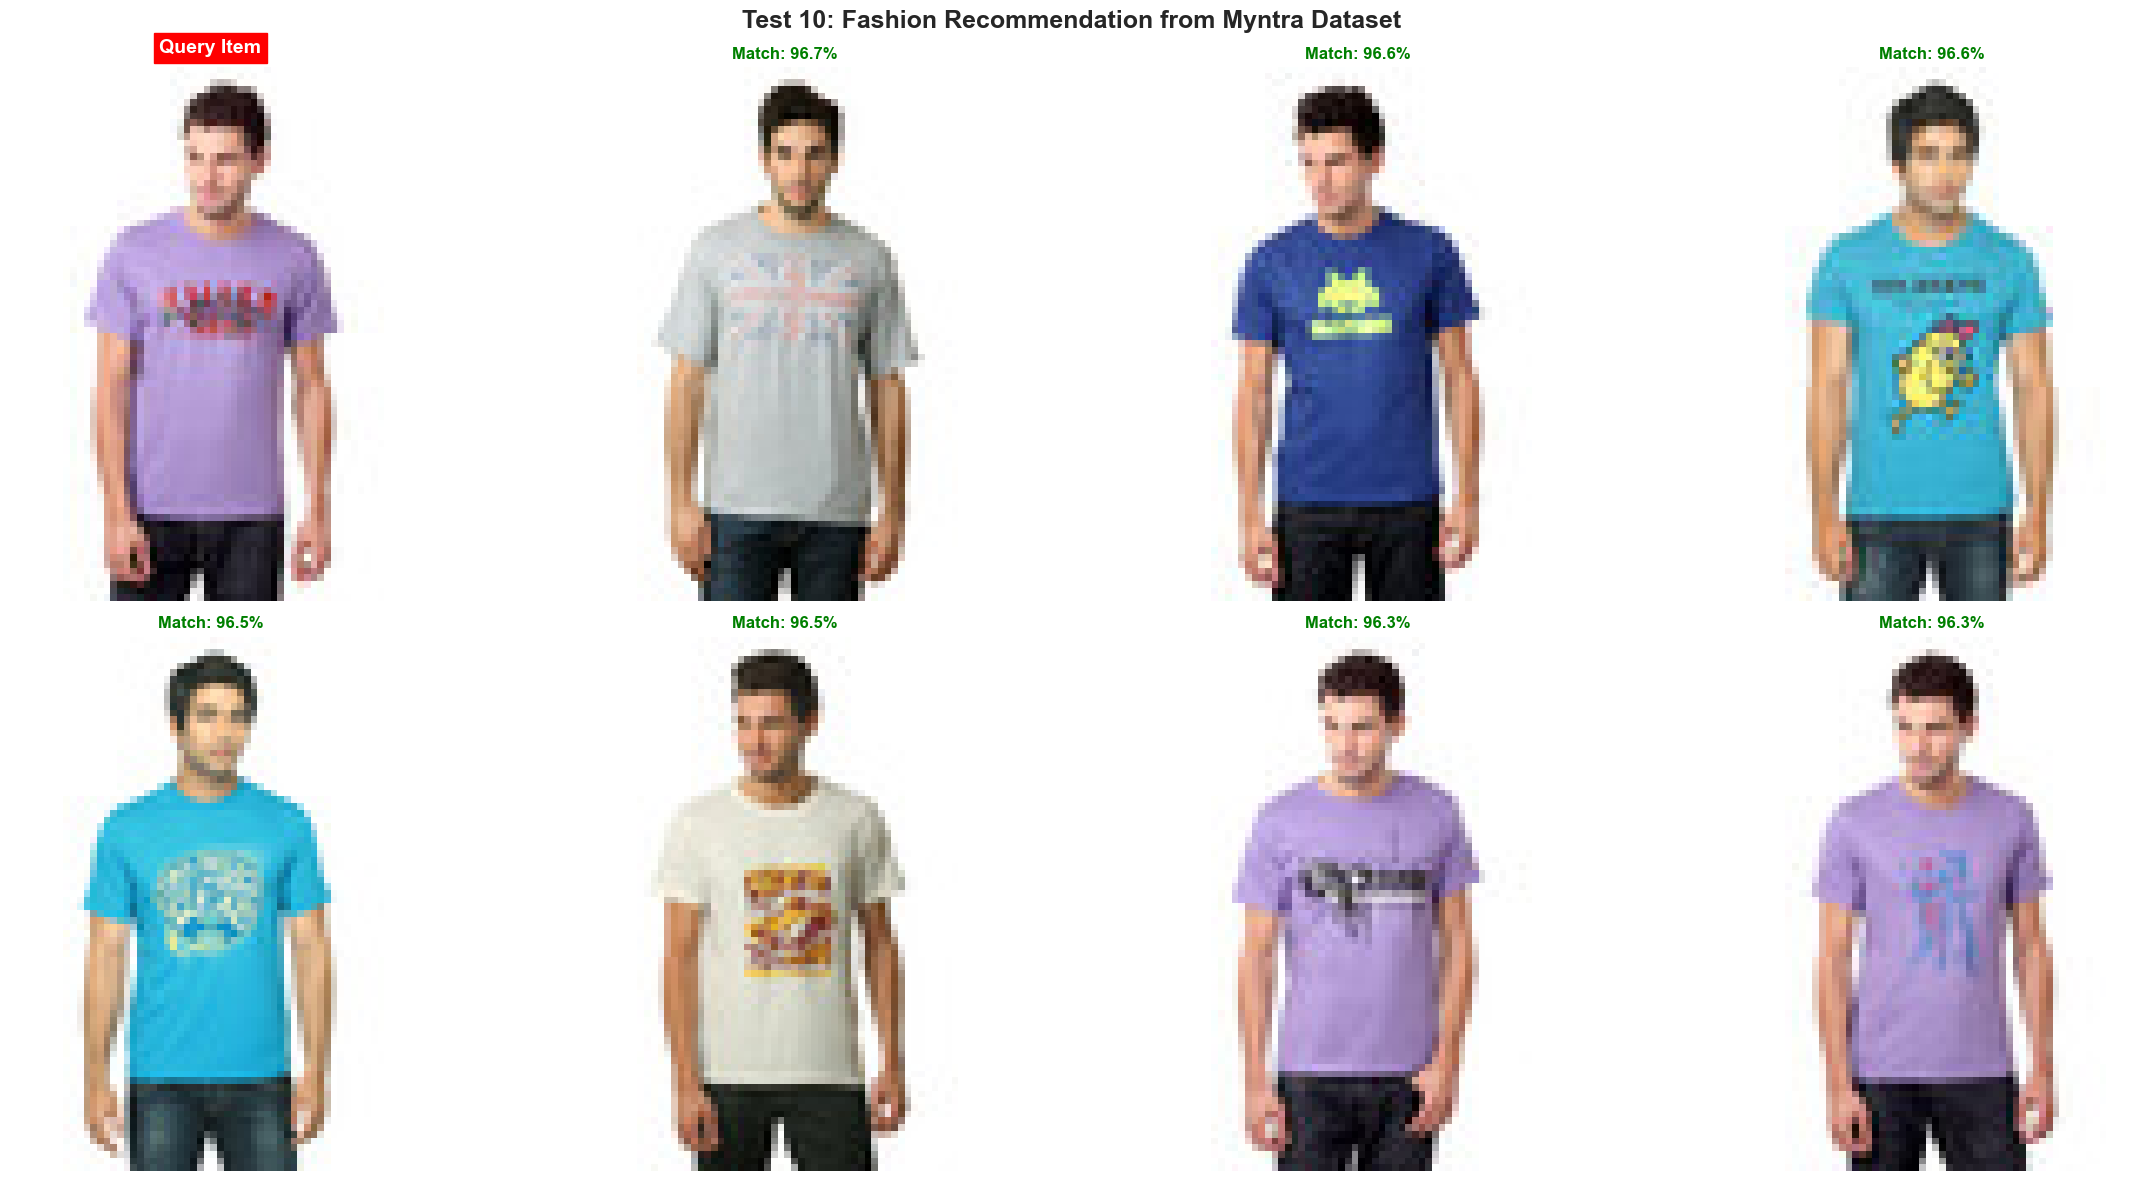

In [10]:
n_test = min(10, len(fashion_df))

for test_num in range(n_test):
    test_idx = np.random.randint(0, len(fashion_df))
    query_item = fashion_df.iloc[test_idx]

    query_features = features_array[test_idx].reshape(1, -1)
    distances, indices = knn_model.kneighbors(query_features, n_neighbors=8)

    # Remove the query itself
    indices = indices[0][1:]
    distances = distances[0][1:]

    recommendations = fashion_df.iloc[indices].copy()
    recommendations['similarity'] = 1 - distances

    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    fig.suptitle(
        f"Test {test_num + 1}: Fashion Recommendation from Myntra Dataset",
        fontsize=18,
        fontweight='bold'
    )

    # Show Query Image
    try:
        query_img = Image.open(query_item['image_path'])
        axes[0, 0].imshow(query_img)
        axes[0, 0].set_title(
            'Query Item',
            fontweight='bold',
            fontsize=14,
            color='white',
            backgroundcolor='red',
            pad=10
        )
        axes[0, 0].axis('off')
    except Exception as e:
        print("Error loading query image:", e)
        axes[0, 0].text(0.5, 0.5, "Error", ha='center', va='center')
        axes[0, 0].axis('off')

    # Show Recommended Images
    for ax, (_, rec) in zip(axes.flat[1:], recommendations.iterrows()):
        try:
            rec_img = Image.open(rec['image_path'])
            ax.imshow(rec_img)
            ax.set_title(
                f"Match: {rec['similarity']:.1%}",
                fontsize=12,
                fontweight='bold',
                color='green'
            )
            ax.axis('off')
        except Exception as e:
            print("Error loading:", rec['image_path'])
            print(e)
            ax.text(0.5, 0.5, "Error", ha='center', va='center')
            ax.axis('off')

    plt.tight_layout()
    plt.show()


In [12]:
os.makedirs('models', exist_ok = True)

np.save('models/fashion_features.npy', features_array)

fashion_df.to_csv('models/fashion_metadata.csv', index = False)

model_data = {
    'features' : features_array,
    'metadata' : fashion_df,
    'feature_extractor_type' : 'resnet18',
    'dataset' : 'myntra',
    'num_items' : len(fashion_df),
    'feature_dim' : features_array.shape[1]
}

joblib.dump(model_data, 'models/fashion_recommender.pkl')

file_size = os.path.getsize('models/fashion_recommender.pkl')/(1024**2)
file_size

89.0264368057251